<a href="https://colab.research.google.com/github/jehasbani/music_generator/blob/master/lstm_music_generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [29]:
from music21 import *
import numpy as np
import os
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.layers import *
from keras.models import *
from keras.callbacks import *
import keras.backend as K
import random

In [52]:
def read_midi(file):
  notes = []
  notes_to_parse = None
  midi = converter.parse(file)

  s2 = instrument.partitionByInstrument(midi)
  print(s2)
  for part in s2.parts:
    print(part)
    if 'Piano' in str(part):
      notes_to_parse = part.recurse()
      for element in notes_to_parse:
        if isinstance(element,note.Note):
          notes.append(str(element.pitch))
        elif isinstance(element,chord.Chord):
          notes.append('.'.join(str(n) for n in element.normalOrder))
  return np.array(notes)

# Uploading  data

In [3]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [4]:
cwd = '/content/drive/My Drive/music_generator'
files_path = os.path.join(cwd,'schubert')

In [5]:
files = [i for i in os.listdir(files_path) if i.endswith('.mid')]

In [6]:
notes_array = [read_midi(os.path.join(files_path,file)) for file in files]

# Data exploration

In [7]:
notes_ = [element for note_ in notes_array for element in note_]
unique_notes = list(set(notes_))
print(len(unique_notes))

304


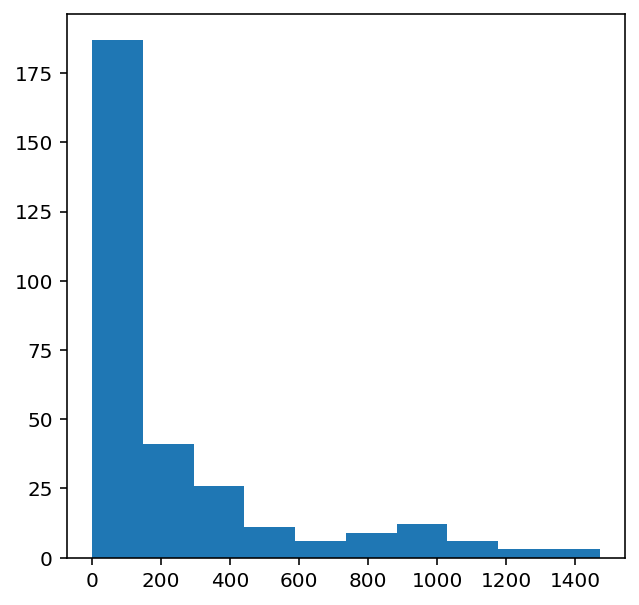

In [8]:
freq = dict(Counter(notes_))
no = [count for note_,count in freq.items()]

plt.figure(figsize=(5,5))
plt.hist(no)
plt.show()

In [9]:
frequent_notes = [note_ for note_,count in freq.items() if count>=50]
print(len(frequent_notes))

167


In [10]:
new_music = []

for notes in notes_array:
  temp = []
  for note_ in notes:
    if note_ in frequent_notes:
      temp.append(note_)
  new_music.append(temp)

new_music = np.array(new_music)

# Preparing data

input and output sequences

In [11]:
n_timesteps = 32
x = []
y = []

for note_ in new_music:
  for i in range(0, len(note_) - n_timesteps, 1):
    input_ = note_[i:i + n_timesteps]
    output = note_[i + n_timesteps]
  
    x.append(input_)
    y.append(output)

x = np.array(x)
y = np.array(y)

unique integer to every note




In [12]:
unique_x = list(set(x.ravel()))
x_note_to_int = dict((note_,number) for number, note_ in enumerate(unique_x))

integer sequences to input data

In [13]:
x_seq = []

for i in x:
  temp = []
  for j in i:
    temp.append(x_note_to_int[j])
  x_seq.append(temp)

x_seq = np.array(x_seq)

Apply to output

In [14]:
unique_y = list(set(y))
y_note_to_int = dict((note_,number) for number, note_ in enumerate(unique_y))
y_seq = [y_note_to_int[i] for i in y]

Train test split

In [22]:
x_train, x_test, y_train, y_test = train_test_split(x_seq, y_seq, test_size = 0.2, random_state=0)

In [23]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=0)

In [24]:
print(f'Train:{len(x_train)}')
print(f'Validation:{len(x_val)}')
print(f'Test:{len(x_test)}')

Train:41224
Validation:10306
Test:12883


# Model definition

## LSTM

In [43]:
K.clear_session()
model = Sequential()
model.add(Embedding(len(unique_x), 100, input_length=32,trainable=True)) 
model.add(LSTM(128,return_sequences=True))
model.add(LSTM(128))
model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dense(len(unique_y)))
model.add(Activation('softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam')

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 32, 100)           16700     
_________________________________________________________________
lstm (LSTM)                  (None, 32, 128)           117248    
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense (Dense)                (None, 256)               33024     
_________________________________________________________________
activation (Activation)      (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 167)               42919     
_________________________________________________________________
activation_1 (Activation)    (None, 167)               0

## WaveNet (modified)

In [17]:
K.clear_session()
model = Sequential()
    
#embedding layer
model.add(Embedding(len(unique_x), 100, input_length=32,trainable=True)) 

model.add(Conv1D(64,3, padding='causal',activation='relu'))
model.add(Dropout(0.2))
model.add(MaxPool1D(2))
    
model.add(Conv1D(128,3,activation='relu',dilation_rate=2,padding='causal'))
model.add(Dropout(0.2))
model.add(MaxPool1D(2))

model.add(Conv1D(256,3,activation='relu',dilation_rate=4,padding='causal'))
model.add(Dropout(0.2))
model.add(MaxPool1D(2))
          
#model.add(Conv1D(256,5,activation='relu'))    
model.add(GlobalMaxPool1D())
    
model.add(Dense(256, activation='relu'))
model.add(Dense(len(unique_y), activation='softmax'))
    
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam')

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 32, 100)           16700     
_________________________________________________________________
conv1d (Conv1D)              (None, 32, 64)            19264     
_________________________________________________________________
dropout (Dropout)            (None, 32, 64)            0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 16, 64)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 16, 128)           24704     
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 128)           0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 8, 128)            0

In [44]:
checkpointer = ModelCheckpoint(os.path.join(cwd,'best_model.h5'), 
                               monitor='val_loss', 
                               mode='min', 
                               save_best_only=True,
                               verbose=1)

In [45]:
history = model.fit(np.array(x_train),
                    np.array(y_train),
                    batch_size=128,
                    epochs=50, 
                    validation_data=(np.array(x_val),np.array(y_val)),
                    verbose=1, callbacks=[checkpointer])

Epoch 1/50
322/323 [============================>.] - ETA: 0s - loss: 4.3080
Epoch 00001: val_loss improved from inf to 3.89962, saving model to /content/drive/My Drive/music_generator/best_model.h5
323/323 [==============================] - 4s 12ms/step - loss: 4.3079 - val_loss: 3.8996
Epoch 2/50
317/323 [============================>.] - ETA: 0s - loss: 3.7716
Epoch 00002: val_loss improved from 3.89962 to 3.69036, saving model to /content/drive/My Drive/music_generator/best_model.h5
323/323 [==============================] - 3s 9ms/step - loss: 3.7711 - val_loss: 3.6904
Epoch 3/50
323/323 [==============================] - ETA: 0s - loss: 3.5823
Epoch 00003: val_loss improved from 3.69036 to 3.55590, saving model to /content/drive/My Drive/music_generator/best_model.h5
323/323 [==============================] - 3s 9ms/step - loss: 3.5823 - val_loss: 3.5559
Epoch 4/50
318/323 [============================>.] - ETA: 0s - loss: 3.4216
Epoch 00004: val_loss improved from 3.55590 to 3.4

In [46]:
model = load_model(os.path.join(cwd,'best_model.h5'))

In [47]:
ind = np.random.randint(0,len(x_test)-1)

random_music = x_test[ind]

predictions=[]
for i in range(10):

    random_music = random_music.reshape(1,n_timesteps)

    prob  = model.predict(random_music)[0]
    y_pred= np.argmax(prob,axis=0)
    predictions.append(y_pred)

    random_music = np.insert(random_music[0],len(random_music[0]),y_pred)
    random_music = random_music[1:]
    
print(predictions)

[12, 85, 83, 12, 12, 80, 122, 50, 11, 50]


In [48]:
x_int_to_note = dict((number, note_) for number, note_ in enumerate(unique_x)) 
predicted_notes = [x_int_to_note[i] for i in predictions]

In [35]:
def convert_to_midi(prediction_output):
   
    offset = 0
    output_notes = []

    # create note and chord objects based on the values generated by the model
    for pattern in prediction_output:
        
        # pattern is a chord
        if ('.' in pattern) or pattern.isdigit():
            notes_in_chord = pattern.split('.')
            notes = []
            for current_note in notes_in_chord:
                
                cn=int(current_note)
                new_note = note.Note(cn)
                new_note.storedInstrument = instrument.Piano()
                notes.append(new_note)
                
            new_chord = chord.Chord(notes)
            new_chord.offset = offset
            output_notes.append(new_chord)
            
        # pattern is a note
        else:
            
            new_note = note.Note(pattern)
            new_note.offset = offset
            new_note.storedInstrument = instrument.Piano()
            output_notes.append(new_note)

        # increase offset each iteration so that notes do not stack
        offset += 1
    midi_stream = stream.Stream(output_notes)
    midi_stream.write('midi', fp=os.path.join(cwd,'music.mid'))


In [49]:
convert_to_midi(predicted_notes)

In [37]:
predicted_notes

['G#4', 'G#4', 'E4', 'G#4', 'G#4', 'G#4', 'E2', 'G#4', 'G#4', 'G#4']